119
(1605, 120)
(1605,)


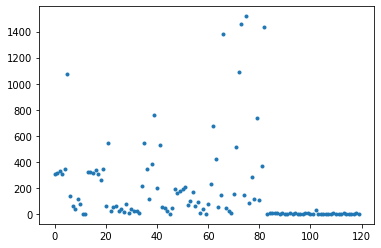

In [1]:
#from joblib import Memory
from sklearn.datasets import load_svmlight_file
#from scipy.sparse import csc_matrix
#from scipy.special import expit
#from scipy import sparse
#from sklearn.preprocessing import normalize
#import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from copy import copy
#from sklearn import svm
#import time
#mem = Memory("./mycache")

def get_data(datafile):
    data = load_svmlight_file(datafile)
    return data[0], data[1]


X, Z = get_data('/Users/tianachargin/Desktop/PythonSG/STAT 4490/a1a.txt')

train = pd.DataFrame(X.todense())

features = train.shape[1]
print(features)
train[features] = 0

m = min(Z)
M = max(Z)
y = (Z-m)/(M-m) # -1 is being convert to 0 


first_column = train. iloc[:, 0]

print(train.shape)
print(y.shape)

plt.plot(np.sum(train.values, axis=0), '.')

(30956, 120) (30956,)


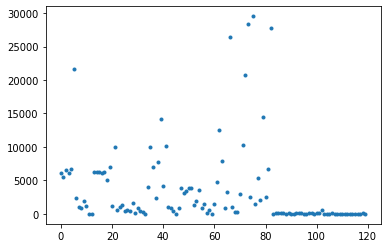

In [2]:
T, u = get_data('/Users/tianachargin/Desktop/PythonSG/STAT 4490/a1a.t')

t = pd.DataFrame(T.todense())
# Create 120rd feature as bias value since only 1 record has a value in training data & it's missing from the test data
t[features] = 0
test = t.iloc[:,0:(features+1)]



m = min(u)
M = max(u)
y_data_test = (u-m)/(M-m)

print(test.shape, y_data_test.shape)


plt.plot(np.sum(test.values, axis=0), '.')

In [3]:
print(m, M)
print(y[0:10])
print(Z[0:10])
print(train.shape, test.shape, features)
print(np.unique(y, return_counts=True))

-1.0 1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]
(1605, 120) (30956, 120) 119
(array([0., 1.]), array([1210,  395]))


In [4]:
#import libraries 
from sklearn.utils import shuffle
from sklearn import metrics
import numpy as np

#Neural Network Class
class NN:
    def __init__(self, data, labels, learning_rate, num_epochs, bsize, num_nodes = (10, 3, 1), print_freq = 10):
        self.x = data #features
        self.y = labels #prediction
        self.lr = learning_rate
        self.epochs = num_epochs
        self.batchsize = bsize
        self.print_freq = print_freq #number will depict how often you want error and accuracy printed 
        
        #list that holds the value/number of the column count of self.x, call this "p"
        self.hs = [self.x.shape[1]] 
        #empty list that will be used for weight matrices 
        self.ws = [] 
        
        #create weight matrices based on what is passed to num_nodes, will be appending lists
        #using for loop in the length of num_nodes allows for flexibility in the number of hidden layers/weights
        #the length of num_nodes reflects the number of hidden layers. num_nodes - 1 = amount of hidden layers
        #since the last value in num_nodes is the output layer
        #each iteration will go through each line
        for i in range(len(num_nodes)):
            #appending number to a list which will be used to create the weight matrices 
            #1st iteration -> [p, h2] default = 10 
            #2nd iteration ->[p, h2, h1] default = 3
            #3rd iteration-> [p, h2, h1, h0] default = 1
            self.hs.append(num_nodes[i])
            #note -> we need to start at the second to the last index [-2] instead of the last index [-1] to get the 
            #first demension of the matrix and then the last index will be the second demension 
            #shapes of the matrix are determined by the columns of the matrix before and the number of nodes is front
            #the size is self.hs[-2] + 1 by self.hs[-1]
            #appending random samples from uniform distribution from -1 to 1 
            #1st iteration -> (p+1, h2) 
            #2nd iteration -> (h2+1, h1)
            #3rd iteration -> (h1+1, h0)
            self.ws.append(np.random.uniform(-1,1, (self.hs[-2] +1, self.hs[-1])))
            #self.ws[0] = w2
            #self.ws[1] = w1
            #self.ws[2] = w0
    
        
    #helper function, will prepend (add to the front) a col of 1's to matrix that is passed
    #this function is useful since we are prepending a numerous column of one's to matrices 
    #np.concatenate function concatenates a sequence of arrays along an existing axis
    #the shape will be determined by xs.shape[0] and 
    #since we only want one column and x amount of rows reshape(-1,1) will accomplish this
    def _prepend_ones(self, xs):
        return np.concatenate((np.ones(xs.shape[0]).reshape(-1,1), xs), axis=1)
    
    
    #batch generator function  
    def _nextBatch2(self):
        #shuffle() randomizes the items of a list in place.
        #RandomState determines random number generation for shuffling the data. Pass an int for reproducible results 
        #across multiple function calls.
        xs, ys = shuffle(self.x, self.y, random_state=None)
        #arange([start,] stop[, step,][, dtype]) : Returns an array with evenly spaced elements as per the interval.
        for i in np.arange(0, xs.shape[0], self.batchsize):
            #yield is a keyword in Python that is used to return from a function without destroying the states of its 
            #local variable and when the function is called, the execution starts from the last yield statement instead
            #of starting all over. 
            yield (xs[i:(i + self.batchsize)], ys[i:(i + self.batchsize)])  
            
    #sig function 
    def sigmoid(self, x):
        val = 1/(1+np.exp(-x))
        return val
            
    #_feedForward function will return an activation for every layer "forward propagation"
    def _feedForward(self, xs):
        
        #list to hold what is being passed in the method
        #at first the list will only hold the x's 
        y = [xs]
        
        #prepend a column of ones to the layer matrix using the helper function 
        #then do a matrix multiplication with that matrix and the weight matrix
        #then apply the sigmoid function and append it to the list(y)
        #once again, using a for loop always for flexibility in the number of hidden layers
        #this time we are using the length of self.ws and what's inside self.ws
        #1st iteration -> y = xs, w2
        #2nd iteration -> y = y2, w1
        #3rd iteration -> y = y1, w0
        #after 3rd iteration y = y
        for i in range(len(self.ws)):
            y_ones = self._prepend_ones(y[-1])
            #1st iteration -> y = [xs, y2]
            #2nd iteration -> y = [xs, y2, y1]
            #3rd iteration -> y = [xs, y2, y1, yhat]
            y.append(self.sigmoid(np.matmul(y_ones, self.ws[i])))
        #return everything in list y except for the first element which are the xs    
        return y[1:] 
    
    #predict function will return most likely class in the last layer, internal function 
    def predict(self, x):
        return self._feedForward(x)[-1] 
    
    
    #fit function will calculate change in weights/weight updates and print error and accuracy, back propagation 
    def fit(self):
        for j in range(self.epochs):
            for batch_x, batch_y in self._nextBatch2():
                
                ys = self._feedForward(batch_x)
                #ys[0] = y2
                #ys[1] = y1
                #ys[2] = Yhat
                #ys[y2, y1, Yhat]

                #yhat - y
                chain = ys[-1] - batch_y.reshape(-1,1) 
                dws = []
                
                #calculate the change in weights for all but the last layer
                #the last layer will be calculated separately since it does a matrix multiplication with x and not y
                #using a for loop allows for flexibility
                #start at 1, shifts where we are starting and ending since we don't want the last weight matrix
                #we don't want to start at index [0] since that's the last layer
                for i in range(1, len(self.ws)):
                    #(yhat-y)* yhat*(1-yhat)
                    #ys[-i] is the last element in list which is yhat
                    ddw = chain * ys[-i]*(1-ys[-i])
                    #insert calculation into dws at index 0, the chain is being transposed
                    #ys[-i -1] is the second to the last
                    dws.insert(0, 2*np.matmul(ddw.T, self._prepend_ones(ys[-i - 1])))
                    #(yhat-y)*yhat*(1-yhat) x weight matrix without the column of one and transposed 
                    chain = np.matmul(ddw, self.ws[-i][1:].T)
                 
                #calculate the chage in weight for the last layer
                #(yhat - y)* yhat * (1-yhat)    
                #ys[0] = y2 or last layer
                ddw = chain * ys[0]*(1-ys[0])
                #insert calculation into dws at index 0, the chain is being transposed
                dws.insert(0, 2*np.matmul(ddw.T, self._prepend_ones(batch_x)))
                
                #calculate the weight updates 
                #for loop allows for flexibility in the amount of hidden layers, depends on the numnber of weight matrices 
                for i in range(len(self.ws)):
                    self.ws[i] -= self.lr*dws[i].T                    
                    #self.ws[0] = w2
                    #self.ws[1] = w1
                    #self.ws[2] = w0
                
            #print when j%self.print_freq equals 0, this is a modulus calculation 
            #j is the num of epochs and self.print is the frequency which is passed or defaulted to 10
            if j%self.print_freq == 0: 
                print('Error at epoch', j, self.error(self.x, self.y))
                print('Accuracy is ', self.score(self.x, self.y), '\n')       
    
    
    #internal function that calculates error
    def error(self, x, y):
        Yhat = self.predict(x)
        return  np.sum((y.reshape(-1,1)-Yhat)**2)
    
    
    #internal function that calculates accuracy 
    def score(self, x, y):
        Yhat = self.predict(x)
        return  1-np.mean(abs(np.round(Yhat-y.reshape(-1,1))))

    
    #the weights output is in a dictionary format, idx is the key and i is the value 
    #f-strings are string literals that have an f at the beginning and curly braces containing expressions that will 
    #be replaced with their values.
    #The enumerate() function assigns an index to each item in an iterable object that can be used to reference the 
    #item later.
    #we want to print from "backwards" starting at w2 but we also want to end at w0 and not w1
    #hence, -idx -1
    def get_params(self):
        return {f"w{len(self.ws) - idx -1}":i for idx,i in enumerate(self.ws)}


#### Note, for the parameter num_nodes the last value in the tuple is for the output layer and any number before that is the number of nodes in that hidden layer. Meaning, the last number in the tuple should always be a 1. 
#### For example, a NN with 2 hidden layers with have three numbers in the num_nodes tuple. -> num_nodes = (3, 2, 1)

In [6]:
model = NN(train, y, learning_rate=0.01, num_epochs=1000, bsize=8, num_nodes = (10, 5, 1), print_freq = 100)

In [6]:
model.fit()
print("Accuracy: ", model.score(test, y_data_test))
model.get_params()

Error at epoch 0 292.03718135402426
Accuracy is  0.7538940809968847 

Error at epoch 100 157.4634412686387
Accuracy is  0.8697819314641745 

Error at epoch 200 143.64541354185886
Accuracy is  0.8803738317757009 

Error at epoch 300 120.02916269254425
Accuracy is  0.9090342679127725 

Error at epoch 400 97.5880269559153
Accuracy is  0.9320872274143303 

Error at epoch 500 78.92747105665599
Accuracy is  0.9501557632398754 

Error at epoch 600 63.52803580822848
Accuracy is  0.9601246105919004 

Error at epoch 700 51.39098780200502
Accuracy is  0.9688473520249221 

Error at epoch 800 51.34912573315584
Accuracy is  0.9657320872274143 

Error at epoch 900 43.52376875353046
Accuracy is  0.9719626168224299 

Accuracy:  0.805110479390102


{'w2': array([[ 0.82706564, -0.78893117, -0.32721479, ...,  0.45904136,
          0.64978691, -0.46972186],
        [ 0.72518391,  0.59774096, -0.25669829, ..., -1.39205838,
          0.17163099,  1.01135361],
        [-0.08666039, -0.02000973,  0.81034538, ...,  0.33608342,
          0.29403357, -1.09303209],
        ...,
        [ 0.57556475,  0.37106489,  0.10945804, ...,  0.5190409 ,
         -0.61987251, -0.94641673],
        [ 0.17217937,  0.77804441, -0.14839769, ..., -0.26772535,
          0.68305945,  0.59562976],
        [-0.27852549, -0.17884013, -0.3191175 , ...,  0.55418016,
         -0.56541838,  0.83168227]]),
 'w1': array([[ 0.29423786,  0.33370988, -0.0510959 ,  0.68060026, -0.8714228 ],
        [-0.47593145, -0.22411639, -0.58331355,  0.54214707,  0.06571783],
        [-0.36676977,  3.74013969,  0.20224261,  4.99477133, -3.73374012],
        [ 0.56759744, -2.92459073, -0.98637919, -4.22861731,  3.40518903],
        [ 1.26147115, -1.24590214, -0.81248263, -1.4572012 , 

In [7]:
model.predict(train)

array([[0.36704801],
       [0.37753552],
       [0.36745635],
       ...,
       [0.35226958],
       [0.37796496],
       [0.38038894]])